In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.style.use('classic')
import time
from collections import namedtuple

import os
import os.path as path
from os import listdir 
from os.path import isfile, join
import copy
import pickle
from tqdm import tqdm
from torchsummary import summary

In [16]:
import os
from os.path import join

# path
cwd = os.getcwd()
parts = cwd.split('/scripts/pretrained')
ROOT = parts[0]
os.chdir(ROOT)
import sys
sys.path.insert(0, ROOT)

In [17]:
from IDNN.intrinsic_dimension import estimate, block_analysis

In [18]:
narchs = 14
EXPERIMENT ='last_hidden'

In [19]:
results_folder = join(ROOT, 'data', 'pretrained', 'results_provided', EXPERIMENT)

# uncomment this line if you want to check your own results
#results_folder = join(ROOT, 'data', 'pretrained', 'results', EXPERIMENT)

In [20]:
archs = ['alexnet', 'vgg11', 'vgg13', 'vgg16','vgg19',
                    'vgg11_bn', 'vgg13_bn', 'vgg16_bn','vgg19_bn',
                    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

perfs_top5 = [20.91, 11.37, 10.75, 9.62, 9.12,
                10.19,  9.63, 8.50, 8.15,
                10.92,  8.58, 7.13, 6.44, 5.94]              

In [21]:
D = dict(zip(archs,perfs_top5))

In [24]:
# variability of ID estimates, these numbers must be consistent with the one in the script last_hidden.sh
divs = 2
reps=  2

ID = []
for arch in tqdm(archs[:narchs]):   
    Id = np.load(join(results_folder, arch + '.npy'))
    means = [np.mean(Id[i,:,0]) for i in range(divs)]
    ID.append( (np.mean(means), np.std(means) ) )  
ID = np.asarray(ID)

100%|██████████| 14/14 [00:00<00:00, 2910.26it/s]


In [25]:
def get_color(arch):
    if 'alex' in arch:
        color = 'r'
    if 'vgg' in arch:
        color = 'b'
    if 'bn' in arch:
        color = 'k'
    if 'res' in arch:
        color = 'g'
    if 'dense' in arch:
        color = 'm'
    if 'squeeze' in arch:
        color = 'y'
    return color   

In [26]:
def get_tag_arch(arch):
    if 'alex' in arch:
        tag_arch = ''
    if 'vgg' in arch:
        parts = arch.split('vgg')
        tag_arch = parts[1]
    if 'bn' in arch:
        parts = arch.split('vgg')
        a = parts[1]
        parts = a.split('_')
        tag_arch = parts[0]
    if 'res' in arch:
        parts = arch.split('resnet')
        tag_arch = parts[1]
    if 'dense' in arch:
        parts = arch.split('densenet')
        tag_arch = parts[1]
    if 'squeeze' in arch:
        parts = arch.split('squeeze')
        tag_arch = parts[1]
    return tag_arch   

def get_sym_arch(arch):
    #print(arch)
    if 'alex' in arch:
        sym_arch = 'o'
    if 'vgg' in arch:
        sym_arch = 'o'
    if 'bn' in arch:
        sym_arch = 'p'
    if 'res' in arch:
        sym_arch = 's'
    if 'dense' in arch:
        sym_arch = 'H'
    if 'squeeze' in arch:
        sym_arch = '1'
    return sym_arch   

In [27]:
ms3 = 10
msexp = [1,
         1,1.1,1.2,1.3,
         1,1.1,1.2,1.3,
         1,1.1,1.2,1.3,1.4]

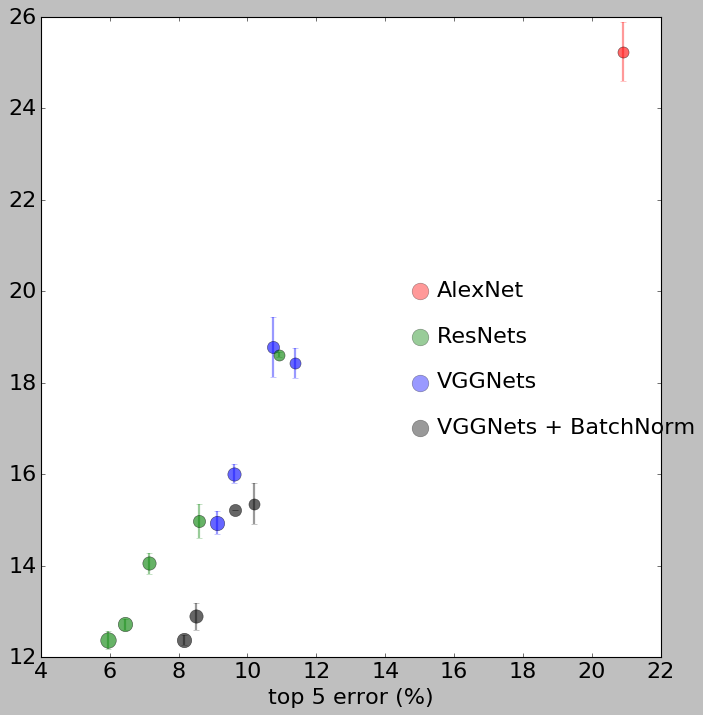

In [29]:
perfs = perfs_top5

plt.style.use('classic')

alpha = 0.4
alpha2=0.8

if OUT_SHAPES:
    ms = 0.2
else:
    ms = 15
ms2 = 15

fs = 20
fs2 = 15
fs3 = 10
lw = 2

fig = plt.figure(figsize=(10,10))
for i,arch in enumerate(archs[:14]):
    if OUT_SHAPES:
        plt.plot(perfs[i], ID[i,0], get_color(arch) + get_sym_arch(arch), markersize=ms*np.log2(out_shapes[i])**2, alpha=alpha)
    
    plt.plot(perfs[i], ID[i,0], get_color(arch) + 'o', markersize=ms3*msexp[i],
             alpha=0.6)
      
    plt.errorbar(perfs[i], ID[i,0], yerr=ID[i,1], fmt= get_color(arch) + '-', linewidth=lw, alpha=alpha)
    
plt.yticks(fontsize=fs)    
plt.xticks(fontsize=fs)

offset = 0
plt.plot(15, offset + 20,'ro',markersize=ms2, alpha=alpha)
plt.plot(15, offset + 19,'go',markersize=ms2, alpha=alpha)
plt.plot(15, offset + 18,'bo',markersize=ms2, alpha=alpha)
plt.plot(15, offset + 17,'ko',markersize=ms2, alpha=alpha)

plt.text(15 + 0.5, offset + 20 - 0.1,'AlexNet',fontsize=fs)
plt.text(15 + 0.5, offset + 19 - 0.1,'ResNets',fontsize=fs)
plt.text(15 + 0.5, offset + 18 - 0.1,'VGGNets',fontsize=fs)
plt.text(15 + 0.5, offset + 17 - 0.1,'VGGNets + BatchNorm',fontsize=fs)

plt.xlabel('top 5 error (%)', fontsize=fs)
plt.savefig(join(results_folder, 'Fig4.png'))

plt.show()